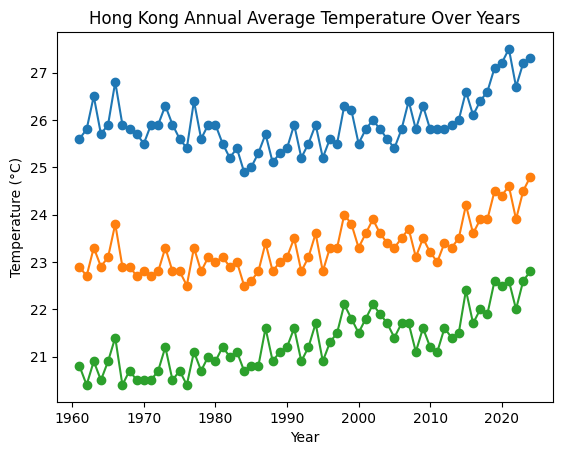

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#read hk temperature data
avg_temp = pd.read_csv('hktemp.csv')
#using plt show high avg avg and low avg temperature
plt.plot(avg_temp['Year'], avg_temp['avg_high_temp'], marker='o', label='High Avg Temp')
plt.plot(avg_temp['Year'], avg_temp['avg_temp'], marker='o', label='Avg Temp')
plt.plot(avg_temp['Year'], avg_temp['avg_low_temp'], marker='o', label='Low Avg Temp')
plt.title('Hong Kong Annual Average Temperature Over Years')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.show()

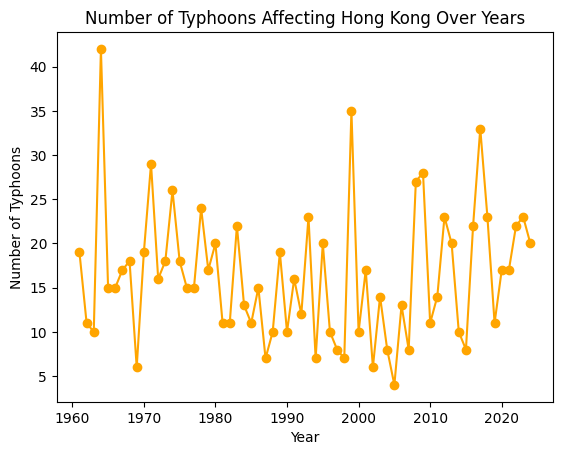

In [23]:
typhoon_num = pd.read_csv('hktyphoon.csv')
combine_list = typhoon_num['1'] + typhoon_num['3'] + typhoon_num['8_Total'] + typhoon_num['9'] + typhoon_num['10']
plt.plot(typhoon_num['Year'], combine_list, marker='o', color='orange')
plt.title('Number of Typhoons Affecting Hong Kong Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Typhoons')
plt.show()



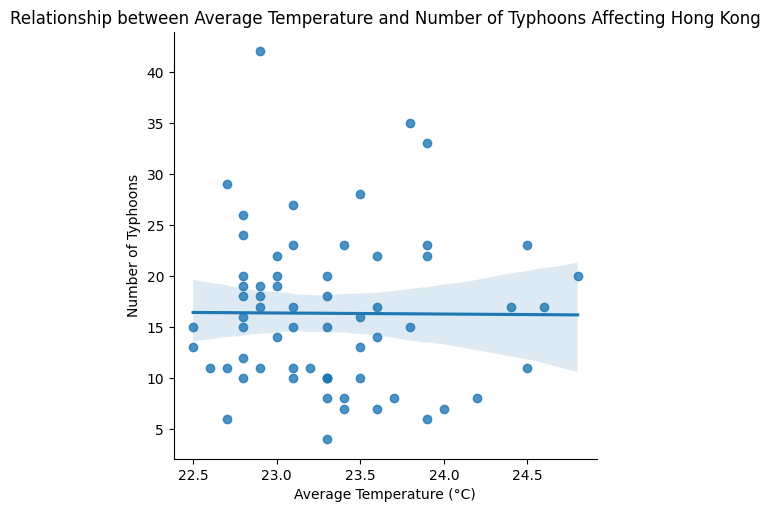

In [26]:
#Relationship between Temperature and Typhoon Numbers
#Linear/Logistic Regression with output graphs 
import seaborn as sns
# Merge temperature and typhoon data on Year
merged_data = pd.merge(avg_temp, typhoon_num, on='Year')
# Calculate total typhoons affecting Hong Kong
merged_data['Total_Typhoons'] = merged_data['1'] + merged_data['3'] + merged_data['8_Total'] + merged_data['9'] + merged_data['10']
# Plot relationship between average temperature and total typhoons
sns.lmplot(x='avg_temp', y='Total_Typhoons', data=merged_data)
plt.title('Relationship between Average Temperature and Number of Typhoons Affecting Hong Kong')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Number of Typhoons')
plt.show()


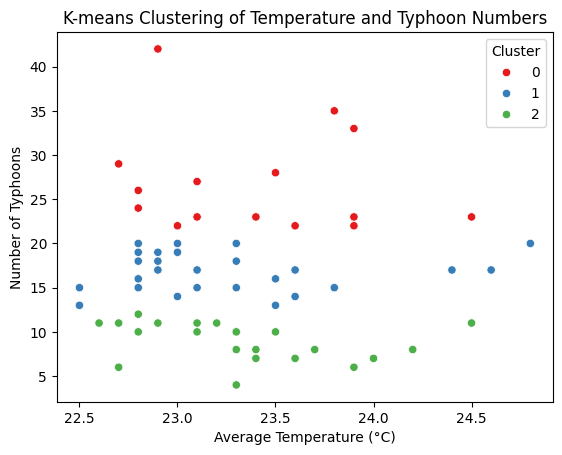

In [28]:
#K-means then output as plt.show
# --- IGNORE ---
from sklearn.cluster import KMeans
kmeans_data = merged_data[['avg_temp', 'Total_Typhoons']].dropna()
kmeans = KMeans(n_clusters=3)
kmeans.fit(kmeans_data)
kmeans_data['Cluster'] = kmeans.labels_
sns.scatterplot(x='avg_temp', y='Total_Typhoons', hue='Cluster', data=kmeans_data, palette='Set1')
plt.title('K-means Clustering of Temperature and Typhoon Numbers')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Number of Typhoons')
plt.show()
 
